In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# now the grid is chaned to 9 *6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'outputs/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



(1280, 720)


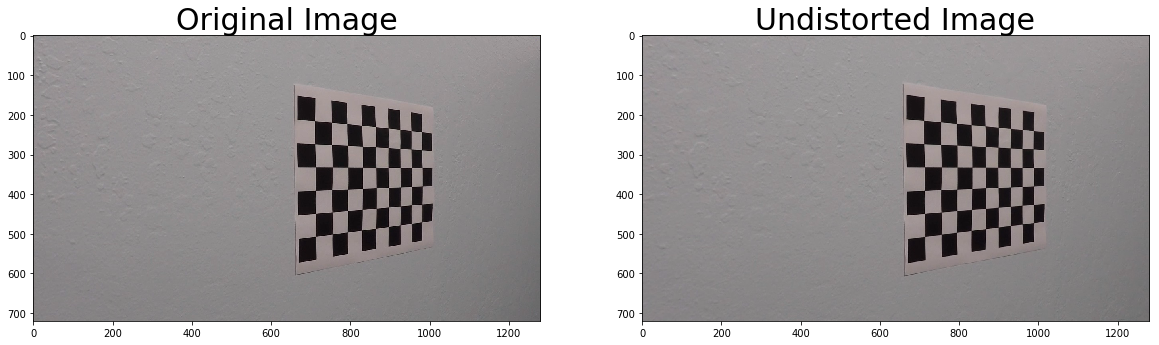

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration8.jpg')
img_size = (img.shape[1], img.shape[0])

print(img_size)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('outputs/undis_calibration8.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "outputs/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)



In [3]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

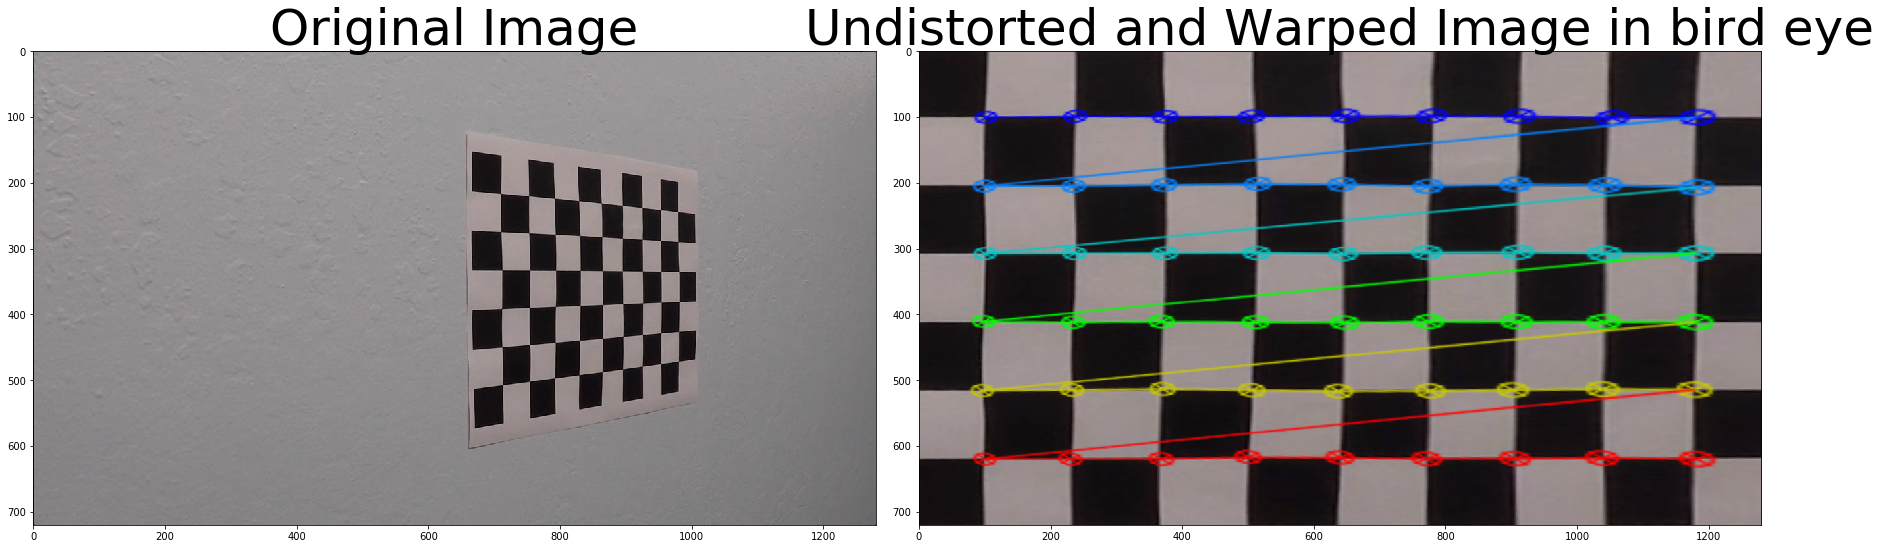

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "outputs/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration8.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image in bird eye', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

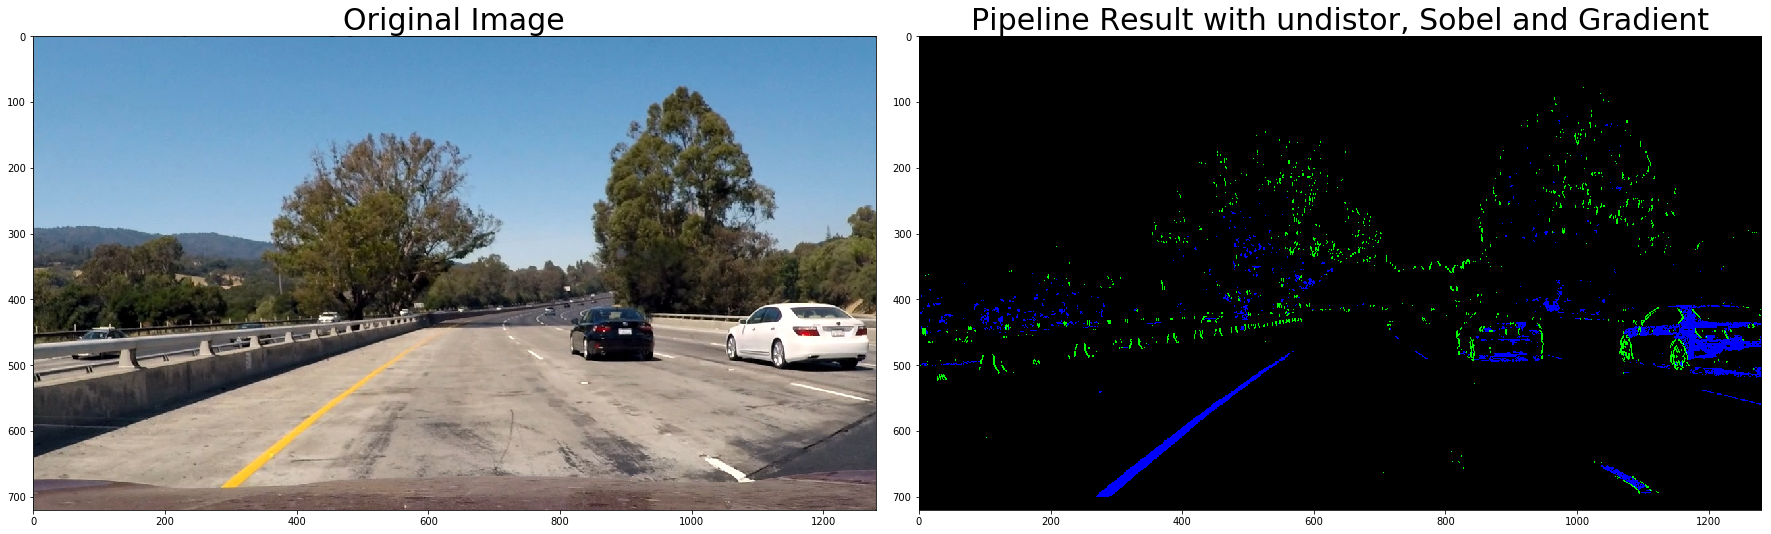

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('./test_images/test1.jpg')

undst = cv2.undistort(image, mtx, dist, None, mtx)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
sobel_grad = pipeline(undst, (190, 255), (60, 180))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(sobel_grad)
ax2.set_title('Pipeline Result with undistor, Sobel and Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

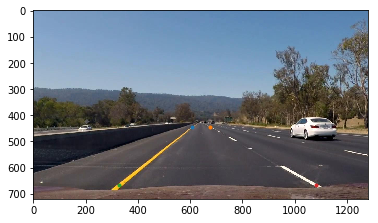

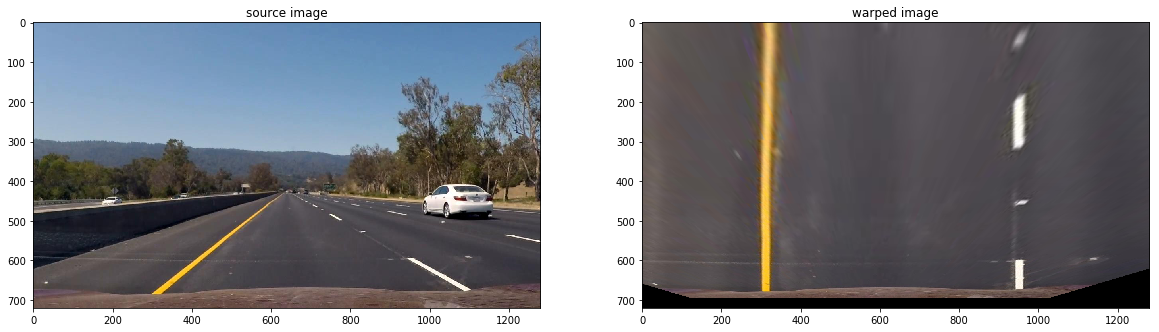

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# this ismage is extract from vidoe
img = mpimg.imread('parall.jpg')

#img = mpimg.imread('./test_images/straight_lines1.jpg')

plt.imshow(img)

plt.plot(607, 446, '.')
plt.plot(676, 446, '.')
plt.plot(329, 667, '.')
plt.plot(1081, 667, '.')

def warp(img):
    img_size = (img.shape[1], img.shape[0])
#     src = np.float32(
#     [[607, 446],
#      [676, 446],
#      [329, 667],
#      [1081, 667]])
 
#     dest = np.float32(
#      [[329, 0],
#       [1081, 0],
#       [329, 667],
#      [1081, 667]])
    
    src = np.float32(
    [[577, 469],
     [723, 469],
     [329, 667],
     [1081, 667]])
    dest = np.float32(
     [[310, 0],
      [950, 0],
      [310, 667],
     [950, 667]])
    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

warped_im, M, Minv = warp(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('source image')
ax1.imshow(img)
ax2.set_title('warped image')
ax2.imshow(warped_im)

(720, 1280, 3)
(1280, 720)
(720, 1280)


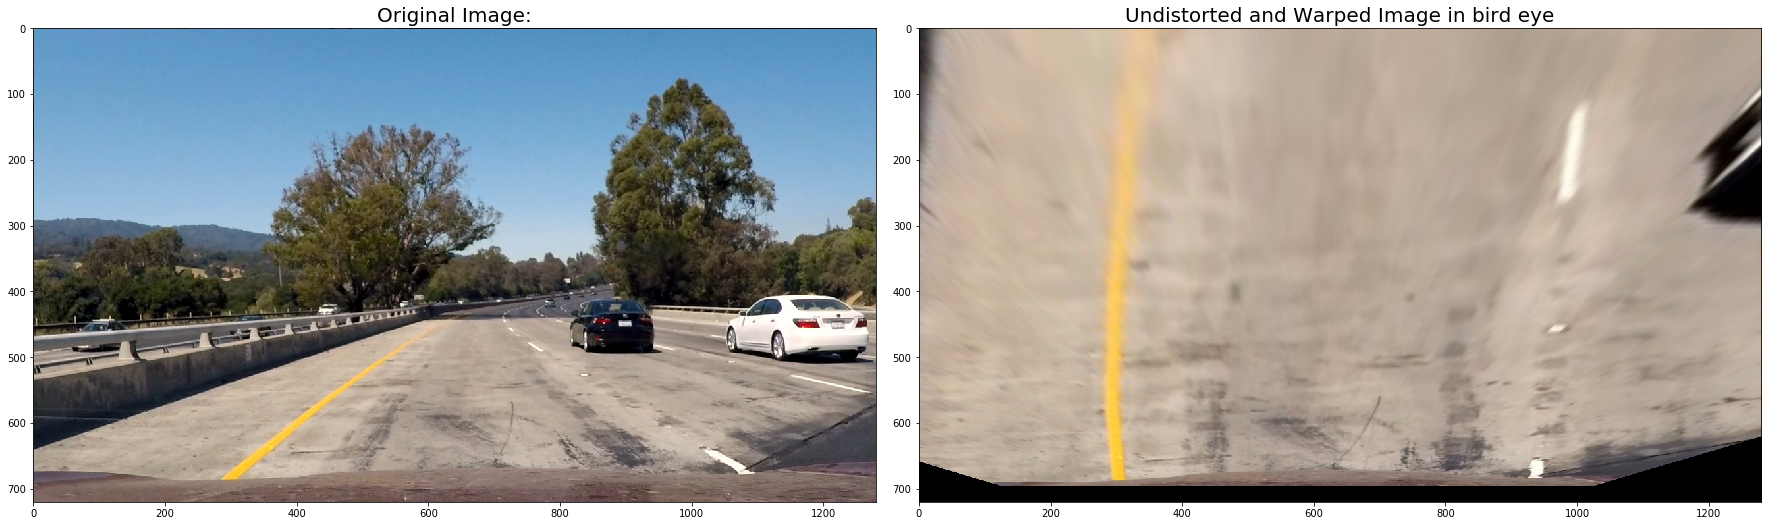

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#image = cv2.imread('./test_images/test1.jpg')
image = mpimg.imread('./test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
img_size = (image.shape[1], image.shape[0])
print(sobel_grad.shape)
print(img_size)
print(gray.shape)

warped = cv2.warpPerspective(undist, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image:', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image in bird eye', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)
(720, 1280, 3)
(1280, 720)
warped image size: (720, 1280, 3)


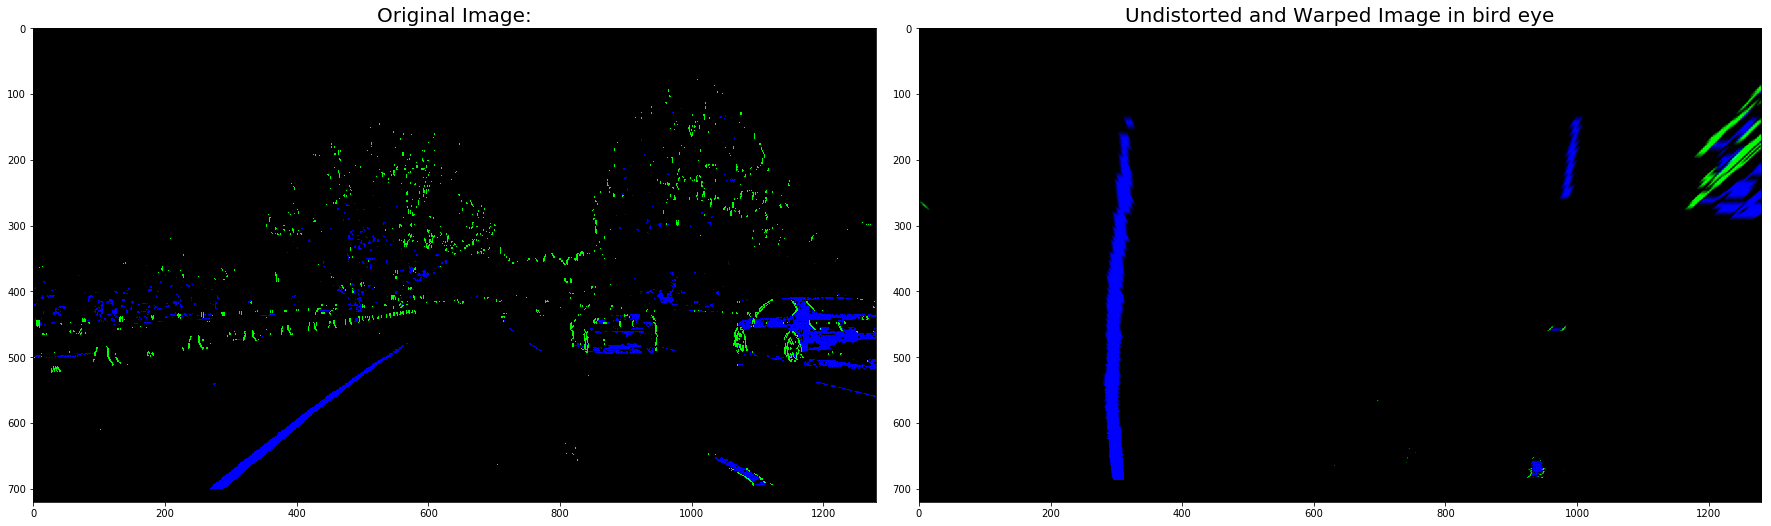

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(sobel_grad.shape)

img_size = (sobel_grad.shape[1], sobel_grad.shape[0])
print(sobel_grad.shape)
print(img_size)

warped = cv2.warpPerspective(sobel_grad, M, img_size)

print("warped image size: {}".format(warped.shape))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sobel_grad)
ax1.set_title('Original Image:', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image in bird eye', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

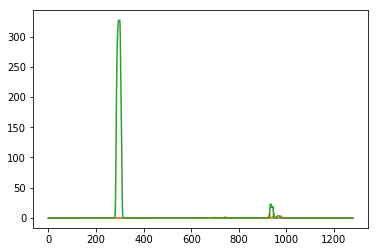

In [9]:
import numpy as np
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [11]:
binary_warped = warped[:,:,2]

#gray = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY) 

import numpy as np
import cv2
import matplotlib.pyplot as plt5
#%matplotlib qt5
%matplotlib inline

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8')

#out_img = 255*np.dstack((gray, gray, gray)).astype('uint8')

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

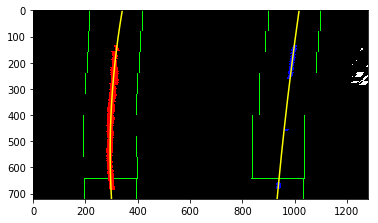

In [12]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
#todo
# extract two consecutive frame from vidoe and  try out the skip windows search.

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)